<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_11_Unsupervised_Learning_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

**Packages for data handling and visualization**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

**Packages for data analysis and modelling**

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

**Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in Week 5 notebook, grant Colab access to your Google Drive and import it to the current notebook. You would need to authenicate yourself. 

Alternatively, when you are working on your own analysis, you may also put everything (i.e. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment. 


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   IN_HOSP_DEATH                     58976 non-null  int64  
 7   DIAGNOSIS                         58951 non-null  object 
 8   MARITAL_STATUS                    58976 non-null  object 
 9   INSURANCE                         58976 non-null  object 
 10  LANGUAGE                          58976 non-null  object 
 11  RELIGION                          58976 non-null  object 
 12  ETHN

# Principal Component Analysis (PCA)

![](https://blog.bioturing.com/wp-content/uploads/2018/11/Blog_pca_6b.png)

([Source](https://blog.bioturing.com/2018/06/14/principal-component-analysis-explained-simply/))

Here, we attempt to reduce the dimensions of the dataset by PCA. By evaluating the extracted principal components (PC), we can also know which variables contain the most unique information and which variables are redundant.

In [6]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

In [7]:
X = df[features_list]

# note that we do not define y as we do not have a prediction target in PCA or unsupervised learning

We can use the function `PCA()` from Scikit-learn to perform PCA. Similar to other Scikit-learn models, we first define a model, then train it using `.fit()`. Here, we specify that we want to retain 5 PCs. 

It is advisable to start with a smaller number of PCs and see if the explained variance ratio is satisfactory (depending on size and quality of dataset, this could range between 70% to 99%). If this number is too low, you could increase the number of PCs through the input `n_components` then retrain your model. Note that having more PCs could limit the explainability or understandability of your model, especially under a clinical context. 

In [8]:
# 1. Specify a model to be trained
model_pca = PCA(n_components = 5)

# 2. Train the model
model_pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

After training the model, we should first use `.explained_variance_ratio_` to check how much variance from the original features is retained by the PCs. In this case, we add them up and we can see that 98.3% of the variance is retained from the first 5 PCs, which is very satisfactory. It is also even permissible to retain only 3 PCs (89.6% explained). 

In [9]:
model_pca.explained_variance_ratio_

array([0.55355616, 0.22882647, 0.11327665, 0.05880889, 0.02851439])

In [10]:
sum(model_pca.explained_variance_ratio_)

0.9829825558945441

To understand what information is captured from each PC, we can evaluate their respective item loadings. In the code below, we first apply the formula for computing item loadings, then convert the results to a DataFrame for easier use later. 

In [11]:
df_pca_loadings = pd.DataFrame(model_pca.components_.T * np.sqrt(model_pca.explained_variance_) / np.std(X).values.reshape((len(features_list), 1)), 
                               index = features_list,  
                               columns = ['PC' + str(i + 1) for i in range(model_pca.n_components_)]
                               )

df_pca_loadings

,PC1,PC2,PC3,PC4,PC5
GENDER_F,-0.025357,0.023450,-0.038113,-0.004447,-0.025660
AGE,0.222402,0.851907,-0.473275,0.024351,0.010205
LOS,0.111916,-0.191103,-0.160873,0.904682,-0.252708
LOS_ICU,0.207704,-0.284876,-0.049304,0.857235,-0.100492
CALLOUT_COUNT_DAY,-0.131883,0.274067,0.017314,-0.132726,0.004162
PRES_COUNT_DAY,0.296749,0.544390,0.340249,-0.023534,0.201557
PROC_COUNT_DAY,0.275845,0.176669,0.284953,-0.145025,0.018990
CPT_COUNT_DAY,0.190016,0.473681,0.266124,0.164756,0.179857
LAB_COUNT_DAY,0.662923,0.518977,0.519200,-0.003799,-0.146008
INPUTS_CV_COUNT_DAY,0.969787,-0.218506,-0.097614,-0.018949,0.042575


For each PC, we then extract the 5-most important features, as defined as the ones with the greatest loading in magnitude. 

In [12]:
for col_name in df_pca_loadings.columns:
  tmp_df = df_pca_loadings[[col_name]].sort_values(by = col_name, key = lambda value: abs(value), ascending = False).head(5)
  print(tmp_df)
  print()

                          PC1
INPUTS_CV_COUNT_DAY  0.969787
LAB_COUNT_DAY        0.662923
OUTPUT_COUNT_DAY     0.593378
PRES_COUNT_DAY       0.296749
PROC_COUNT_DAY       0.275845

                                       PC2
AGE                               0.851907
ADMISSION_TYPE_NEWBORN           -0.741343
MARITAL_STATUS_UNKNOWN (DEFAULT) -0.615034
PRES_COUNT_DAY                    0.544390
INSURANCE_Medicare                0.532009

                          PC3
LAB_COUNT_DAY        0.519200
INPUTS_MV_COUNT_DAY  0.498529
AGE                 -0.473275
INSURANCE_Medicare  -0.368543
PRES_COUNT_DAY       0.340249

                          PC4
LOS                  0.904682
LOS_ICU              0.857235
TRANSFER_COUNT_DAY  -0.445099
INPUTS_MV_COUNT_DAY  0.370659
OUTPUT_COUNT_DAY     0.197017

                          PC5
INPUTS_MV_COUNT_DAY  0.643378
OUTPUT_COUNT_DAY     0.335272
LOS                 -0.252708
PRES_COUNT_DAY       0.201557
CPT_COUNT_DAY        0.179857



To summarize the semantic meaning for each PC:

PC | Meaning
---|---
1 | Daily average input, lab and output events
2 | Demographics (Age, Marital status), Newborn or not
3 | Similar to PC1
4 | Length of Stay
5 | Similar to PC1

# Clustering

Clustering refers to a technique of partitioning entities or objects (e.g. patients, diseases) with similar characteristics into distinct groups while maximizing dissimilarity between groups. In clinical datasets, the major objectives of performing clustering could be to:

* Extract insights from the dataset. **Understand** what **subgroups or phenotypes** exist within the dataset. (e.g. [discovering asthma subtypes](https://pubmed.ncbi.nlm.nih.gov/18480428/))
* Evaluate the **association** between extracted subgroups with other variables or **clinical outcomes**. (e.g. [subgroups of adult-onset diabetes and their association with outcomes](https://pubmed.ncbi.nlm.nih.gov/29503172/))
* Use the extracted patient groups as one of the features or outcome in a **subsequent prediction model**. (e.g. [modelling and predicting osteoarthritis progression](https://pubmed.ncbi.nlm.nih.gov/30130590/))

K-means clustering and hierachical clustering are two widely used clustering algorithms. 

# K-means Clustering

In K-means, this is achieved by iteratively update groupings and their respective centroids. 

[![](http://shabal.in/visuals/kmeans/random.gif)](http://shabal.in/visuals/kmeans/random.gif)

([Source](http://shabal.in/visuals/kmeans/6.html))

In our example, we will apply K-means clustering to the extracted PCs. Note that we do not apply it on the features `X` directly as K-means clustering works best when used on continuous variables instead of categorical variables. 

First, let's extract the value of the 5 PCs for all hsopital admissions.

In [13]:
X_pc = model_pca.transform(X)
X_pc = pd.DataFrame(X_pc, columns = ['PC' + str(i + 1) for i in range(model_pca.n_components_)]) # convert it to a table

X_pc

,PC1,PC2,PC3,PC4,PC5
0,-19.596362,10.274110,-0.129143,-6.333733,-3.600393
1,-0.537506,-34.382891,15.653990,-3.945888,-3.842432
2,9.233575,8.916890,-11.750359,0.253808,-6.118831
3,-16.358409,32.028072,-20.422678,-3.486111,-2.451824
4,19.546284,26.382608,1.584111,-3.561140,-8.473485
...,...,...,...,...,...
58971,10.201657,3.795167,31.475975,-11.324666,-9.511399
58972,1.963658,31.047396,50.464309,-4.070876,-16.355135
58973,-23.569105,-5.833960,22.793480,-2.033509,17.849464
58974,-21.681307,4.068376,1.234109,-7.017070,-1.768529


Second, we define a K-means model with 4 clusters and train it. Depending on your dataset and research question, you should experiment with different number of clusters.

Similar to 

In [14]:
# 1. Specify a model to be trained
model_kmeans_4 = KMeans(n_clusters = 4, random_state = 1)

# 2. Train the model
model_kmeans_4.fit(X_pc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

Next, extract the cluster number from the model, and append it to a column called 'cluster'. Note that the generated clusters start from 0. 

In [15]:
X_pc['cluster'] = model_kmeans_4.labels_ 
X_pc['cluster'] 

0        0
1        2
2        0
3        0
4        0
        ..
58971    0
58972    0
58973    0
58974    0
58975    0
Name: cluster, Length: 58976, dtype: int32

Plots can help us understand how the dataset is partitioned by the algorithm. Here is an example. Note that while we used all 5 PCs for clustering, we chose the 2-most important PCs for visualization.

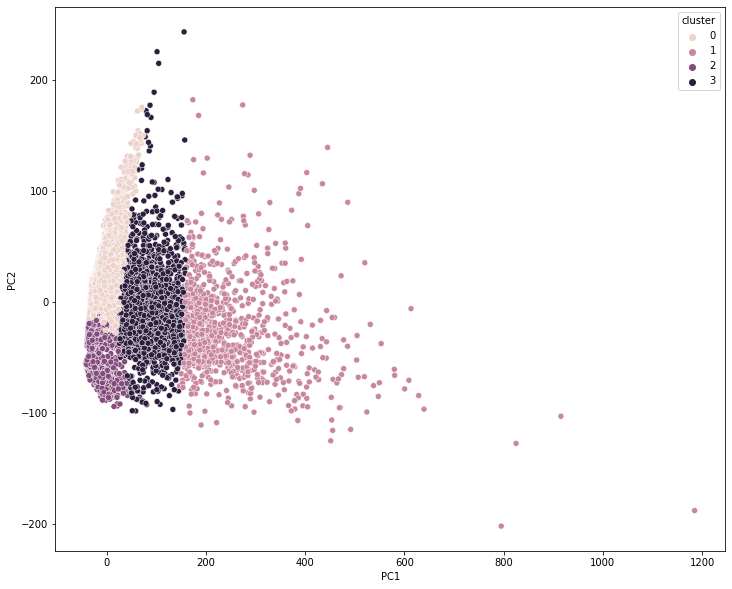

In [16]:
plt.figure(figsize = (12, 10))
sns.scatterplot(data = X_pc, x = 'PC1', y = 'PC2', hue = 'cluster')

Finally, to understand the characteristics of each cluster, we evaluate them by comparing the feature values of each cluster. Data exploration techniques from Week 5 can also be used here.

In [17]:
# make a DataFrame that combines all info: features, PCs and cluster
df_clustered = pd.concat([df, X_pc], axis = 1)
df_clustered.head(5)

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS,PC1,PC2,PC3,PC4,PC5,cluster
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,-19.596362,10.274110,-0.129143,-6.333733,-3.600393,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,0,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,-0.537506,-34.382891,15.653990,-3.945888,-3.842432,2
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,9.233575,8.916890,-11.750359,0.253808,-6.118831,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,90,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,-16.358409,32.028072,-20.422678,-3.486111,-2.451824,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,19.546284,26.382608,1.584111,-3.561140,-8.473485,0


We can calculate some descriptive statistics by group/cluster. You can also apply statistical tests such as t-tests to compare whether there is a significant difference between groups. 

Here, we highlight some distintive features based on the top item loadings above.

---

**Features highly associated with PC 1 and 3**

In [18]:
df_clustered[['INPUTS_CV_COUNT_DAY', 'INPUTS_MV_COUNT_DAY', 'LAB_COUNT_DAY', 'cluster']].groupby('cluster').describe()

INPUTS_CV_COUNT_DAY              ... LAB_COUNT_DAY       
                      count        mean  ...           75%    max
cluster                                  ...                     
0                   40796.0    7.987182  ...     45.166667  283.0
1                     985.0  249.464974  ...    149.750000  507.0
2                   10348.0    9.131588  ...     15.000000   96.0
3                    6847.0   83.131934  ...     65.000000  482.0

[4 rows x 24 columns]

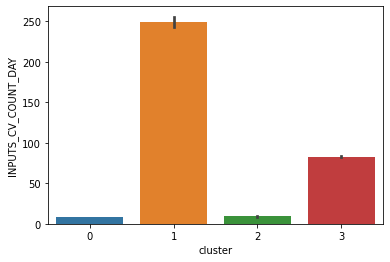

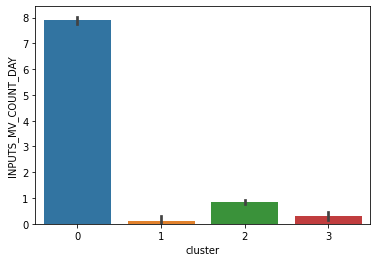

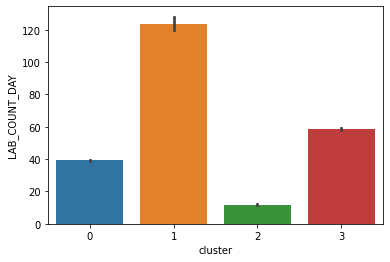

In [19]:
for col_name in ['INPUTS_CV_COUNT_DAY', 'INPUTS_MV_COUNT_DAY', 'LAB_COUNT_DAY']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 1 patients had a high `INPUTS_CV_COUNT_DAY` and `	LAB_COUNT_DAY`.
* Cluster 0 patients had a low `INPUTS_CV_COUNT_DAY` and high `INPUTS_MV_COUNT_DAY`. This, in fact, could be because two different clinical information systems ([CareVue and MetaVision](https://mimic.physionet.org/mimicdata/io/)) were used for different patients in MIMIC-III. The algorithm likely identified those using MetaVision as a seperate group. 

---

**Features highly associated with PC 2**

In [20]:
df_clustered[['AGE', 'ADMISSION_TYPE_NEWBORN', 'cluster']].groupby('cluster').describe()

AGE                                    ... ADMISSION_TYPE_NEWBORN                     
           count       mean        std   min   25%  ...                    min   25%  50%  75%  max
cluster                                             ...                                            
0        40796.0  65.452691  15.413807  16.0  54.0  ...                    0.0  0.00  0.0  0.0  0.0
1          985.0  62.447716  18.583517   0.0  51.0  ...                    0.0  0.00  0.0  0.0  1.0
2        10348.0   6.117994  11.753241   0.0   0.0  ...                    0.0  0.75  1.0  1.0  1.0
3         6847.0  62.794801  18.081391   0.0  52.0  ...                    0.0  0.00  0.0  0.0  1.0

[4 rows x 16 columns]

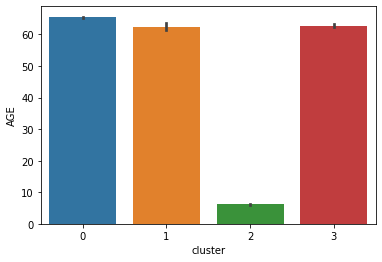

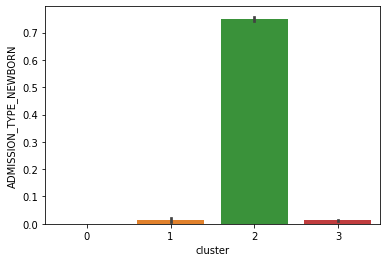

In [21]:
for col_name in ['AGE', 'ADMISSION_TYPE_NEWBORN']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 2 patients are much younger and `ADMISSION_TYPE_NEWBORN` is much more likely to be 1.

**Features highly associated with PC 4**

In [22]:
df_clustered[['LOS', 'LOS_ICU', 'cluster']].groupby('cluster').describe()

LOS                        ... LOS_ICU                     
           count       mean        std  ...     50%        75%       max
cluster                                 ...                             
0        40796.0   9.113110   9.422178  ...  1.9784   3.596075  101.7390
1          985.0  13.093350  14.130382  ...  7.8033  17.815900  153.9280
2        10348.0  11.237096  18.865732  ...  1.1960   6.799925  171.6227
3         6847.0  14.123119  14.691218  ...  6.0646  12.765700  260.7089

[4 rows x 16 columns]

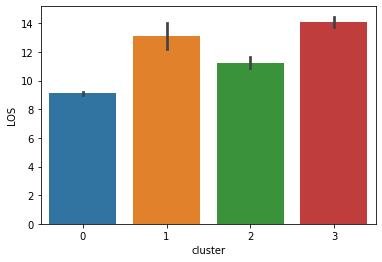

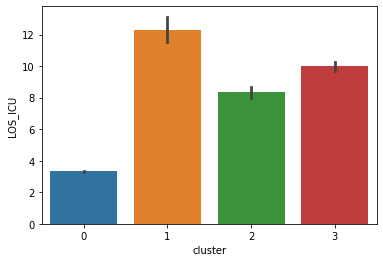

In [23]:
for col_name in ['LOS', 'LOS_ICU']:
  sns.barplot(data = df_clustered, x = 'cluster', y = col_name)
  plt.show()

* Cluster 0 patients had a shorter LOS in ICU while that for cluster 3 patients was longer. 
* The difference between LOS may not be significant. Further statistical analysis is needed to draw conclusions.

**Other Features**

Associating clusters with other variables that were NOT used for clustering could also provide some interesting insights. In this case, `IN_HOSP_DEATH` was not used in clustering but the mortality rates across clusters are found to be quite different. 

In [24]:
df_clustered[['IN_HOSP_DEATH', 'cluster']].groupby('cluster').describe()

IN_HOSP_DEATH                                             
                count      mean       std  min  25%  50%  75%  max
cluster                                                           
0             40796.0  0.085008  0.278898  0.0  0.0  0.0  0.0  1.0
1               985.0  0.748223  0.434254  0.0  0.0  1.0  1.0  1.0
2             10348.0  0.003962  0.062824  0.0  0.0  0.0  0.0  1.0
3              6847.0  0.234847  0.423934  0.0  0.0  0.0  0.0  1.0

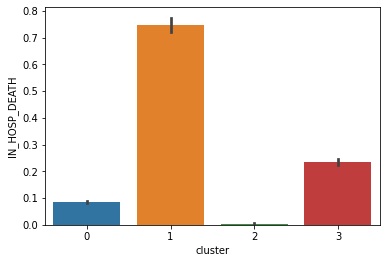

In [25]:
sns.barplot(data = df_clustered, x = 'cluster', y = 'IN_HOSP_DEATH')

* Cluster 1 patients had a remarkably higher mortality rate. 

---

From the results above, we can summarize the meaning for each cluster as follows:

Cluster | Meaning
---|---
0 | Patients using the clinical information system MetaVision
1 | Patients with more events and higher mortality rate 
2 | Newborn
3 | (Remaining Patients)

<br>
From this point, one can extend the cluster analysis by, for example,

* building a predictive model using clusters as one of the features.
* exploring the association between clusters and certain clinical outcomes.

# Reference

* [K-means Clustering: Algorithm, Applications, Evaluation Methods, and Drawbacks](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)